In [1]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
import tensorflow.keras as keras
keras.__version__
import numpy as np
import os, shutil
#import cv

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input,BatchNormalization,Conv2D,MaxPooling2D,Dense,Add,Multiply
from tensorflow.keras.layers import ReLU,GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Lambda,Multiply
from tensorflow.keras import backend as K
from tensorflow.math import divide

import pandas as pd

import math

import h5py


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [111]:
base_dir = '/home/ubuntu/efs/cxr_qc/' # change this path

train_dir = os.path.join(base_dir)
#validation_dir = os.path.join(base_dir, 'validation_dir')

# Training Data
train_excluded = os.path.join(train_dir, 'excluded')
train_included      = os.path.join(train_dir, 'included')

# Validation Data
#val_infiltration = os.path.join(validation_dir, 'infiltration')
#val_none         = os.path.join(validation_dir, 'notinfiltration')


In [112]:
print('Total training excluded images:', len(os.listdir(train_excluded)))
print('Total training included images:', len(os.listdir(train_included)))

Total training excluded images: 855
Total training included images: 587


In [6]:
#Create data and save to h5
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=5,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 1

input_shape=(1024,1024,3)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=input_shape[0:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data



Found 1153 images belonging to 2 classes.
Found 288 images belonging to 2 classes.


In [ ]:
#Create H5 from generators
num_training=6000
num_validation=1200
ff=h5py.File('/home/ubuntu/efs/cxr_qc/cxr_qc_dataset.h5','w')
X_train=ff.create_dataset("X_train",(num_training,) + input_shape,dtype='float32')
y_train=ff.create_dataset("y_train",(num_training,),dtype='float32')

X_val=ff.create_dataset("X_val",(num_validation,) + input_shape,dtype='float32')
y_val=ff.create_dataset("y_val",(num_validation,),dtype='float32')

for ii in range(num_training):
    _tmp=train_generator.next()
    X_train[ii]=_tmp[0]
    y_train[ii]=_tmp[1]
for ii in range(num_validation):
    _tmp=validation_generator.next()
    X_val[ii]=_tmp[0]
    y_val[ii]=_tmp[1]
ff.close()


In [68]:
ff.close()
#ff=h5py.File('/home/ubuntu/efs/cxr_qc/cxr_qc_dataset.h5','r')

#plt.imshow(ff['X_train'][10])
#print(ff['y_train'][10])

In [ ]:


def Model(input_shape=(512,512,3)):
    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=input_shape ))
    model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=input_shape ))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    if input_shape[0]>64:
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3)) 

def Model2(input_shape=(512,512,3)):
    conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)
    conv_base.trainable=False
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    return model

generate_data_onfly=False
if generate_data_onfly=True:
    # All images will be rescaled by 1./255
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=5,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      shear_range=0.1,
                                      zoom_range=0.2,
                                      horizontal_flip=True,validation_split=0.2)
    test_datagen = ImageDataGenerator(rescale=1./255)

    batch_size = 20

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=input_shape[0:2],
        batch_size=batch_size,
        class_mode='binary',
        subset='training') # set as training data

    validation_generator = train_datagen.flow_from_directory(
        train_dir, # same directory as training data
        target_size=input_shape[0:2],
        batch_size=batch_size,
        class_mode='binary',
        subset='validation') # set as validation data

# train_generator = train_datagen.flow_from_directory(
#         # This is the target directory
#         train_dir,
#         # All images will be resized to 150x150
#         target_size = input_shape[0:2],
#         batch_size = batch_size,
#         # Since we use catregorical_crossentropy loss, we need cat. labels
#         class_mode = 'categorical')

# validation_generator = test_datagen.flow_from_directory(
#         validation_dir,
#         target_size = input_shape[0:2],
#         batch_size = batch_size,
#         class_mode = 'categorical')

model=Model2(input_shape)

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [87]:
input_shape

(1024, 1024, 3)

In [3]:
#Model implementation based on:
#https://www.nature.com/articles/s41598-019-42557-4



K.clear_session() 

def conv_block(input_layer,n_filters,length=2,pool=True,stride=1):
    
    layer=input_layer
    for i in range(length):
        layer=Conv2D(n_filters,(3,3),strides=stride,padding='same')(layer)
        layer=BatchNormalization()(layer)
        layer=ReLU()(layer)
        
    parallel=Conv2D(n_filters,(1,1),strides=stride**length,padding='same')(input_layer)
    parallel=BatchNormalization()(parallel)
    parallel=ReLU()(parallel)
    
    output=Add()([layer,parallel])
    output=BatchNormalization()(output)
    #output=Multiply()([output,K.variable(0.5,shape=K.shape(output),dtype='float64',name='const')])
    #output=Multiply()([output,K.ones(shape=K.shape(output))])
    
    #output=Lambda(lambda x: divide(x, 2.0))(output)
    
    if pool:
        output=MaxPooling2D(pool_size=(3,3),strides=2)(output)

    return output

    
def Model3(input_shape,width=1):
    inputs = Input(input_shape)
    
    output=conv_block(inputs,n_filters=16*width,stride=2)
    output=conv_block(output,n_filters=32*width)
    output=conv_block(output,n_filters=48*width)
    output=conv_block(output,n_filters=64*width)

    output=conv_block(output,n_filters=80*width,pool=False)
    
    #Global Average Pooling
    output=GlobalMaxPooling2D()(output)
    
    #Dense
    output=Dense(512,activation='relu')(output)
    output=Dense(2,activation='softmax')(output)
    
    model=Model(outputs=output,inputs=inputs)
    
    return model

model=Model3((1024,1024,3))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

W0324 15:59:13.719405 140429338396416 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
model.summary()
#K.constant

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [100]:
ff=h5py.File('/home/ubuntu/efs/cxr_qc/cxr_qc_dataset.h5','r')
X_t=ff['X_train']
y_t=ff['y_train']
X_v=ff['X_val']
y_v=ff['y_val']
             

In [5]:
from keras.utils.io_utils import HDF5Matrix

X_t=HDF5Matrix('/home/ubuntu/efs/cxr_qc/cxr_qc_dataset.h5','X_train')
y_t=HDF5Matrix('/home/ubuntu/efs/cxr_qc/cxr_qc_dataset.h5','y_train')
X_v=HDF5Matrix('/home/ubuntu/efs/cxr_qc/cxr_qc_dataset.h5','X_val')
y_v=HDF5Matrix('/home/ubuntu/efs/cxr_qc/cxr_qc_dataset.h5','y_val')

Using TensorFlow backend.


In [6]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
model_checkpoint = ModelCheckpoint('modeltest-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#history = model.fit_generator(
#    train_generator,
#    steps_per_epoch=100,
#    epochs=20,
#    validation_data=validation_generator,
#    validation_steps=30,
#    callbacks=[model_checkpoint,earlyStopping])

#history=model.fit(X_train,y_train,batch_size=20,epochs=20,validation_data=(X_val,y_val))
history=model.fit(X_t,y_t,shuffle='batch',batch_size=32,epochs=20,validation_data=(np.array(X_v),y_v),callbacks=[model_checkpoint,earlyStopping])

Train on 6000 samples, validate on 1200 samples
Epoch 1/20
5984/6000 [============================>.] - ETA: 1s - loss: 0.5320 - acc: 0.7543
Epoch 00001: val_loss improved from inf to 0.98164, saving model to modeltest-001-0.754833-0.595000.h5
6000/6000 [==============================] - 764s 127ms/sample - loss: 0.5313 - acc: 0.7548 - val_loss: 0.9816 - val_acc: 0.5950
Epoch 2/20
5984/6000 [============================>.] - ETA: 1s - loss: 0.3386 - acc: 0.8598
Epoch 00002: val_loss did not improve from 0.98164
6000/6000 [==============================] - 708s 118ms/sample - loss: 0.3381 - acc: 0.8602 - val_loss: 1.1737 - val_acc: 0.5950
Epoch 3/20
5984/6000 [============================>.] - ETA: 1s - loss: 0.2616 - acc: 0.8925
Epoch 00003: val_loss improved from 0.98164 to 0.81007, saving model to modeltest-003-0.892833-0.682500.h5
6000/6000 [==============================] - 646s 108ms/sample - loss: 0.2612 - acc: 0.8928 - val_loss: 0.8101 - val_acc: 0.6825
Epoch 4/20
5984/6000 [===

KeyboardInterrupt: 

In [ ]:
#Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [115]:
model.save('qc_cxr-model4.h5')

TypeError: ('Not JSON Serializable:', b'\n\ttruediv_5\x12\x07RealDiv\x1a\tadd_5/add\x1a\x0btruediv_5/y*\x07\n\x01T\x12\x020\x01')

In [ ]:
model.evaluate(X_v,y_v)

In [12]:
#Print images

aa=train_generator.next()
    

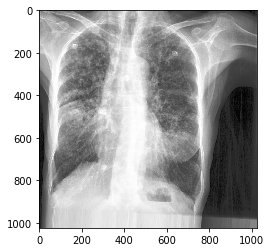

In [27]:
plt.imshow(aa[0][5])

In [ ]:
im = plt.imread('/home/ubuntu/efs/cxr_qc/included/patient57804_frontal.jpg', format='jpeg')

In [2]:
#Test model
model_file='model4-007-0.962333-0.863333.h5'
test_dir='/home/ubuntu/efs/cxr_qc/'


test_datagen = ImageDataGenerator(rescale=1. / 255)
batch_size=32
input_shape=(1024,1024,3)

test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=input_shape[0:2],
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)



Found 1441 images belonging to 2 classes.


In [3]:
model=load_model(model_file)
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator)

W0324 22:13:48.525240 140393269061376 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0324 22:13:48.526623 140393269061376 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0324 22:13:48.527618 140393269061376 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/p

In [15]:
import pandas as pd
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":100*pred[:,1]})


In [17]:
results['Type']=results['Filename'].apply(lambda x: x.split('/')[0])

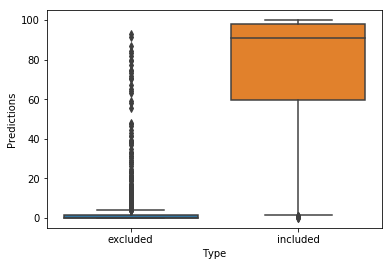

In [20]:
import seaborn as sns
import matplotlib.pylab as plt
sns.boxplot(x='Type',y='Predictions',data=results)

In [109]:
results[results['Predictions']>15].groupby('Type').count()/results.groupby('Type').count()

,Filename,Predictions
Type,,
excluded,0.091228,0.091228
included,0.906143,0.906143


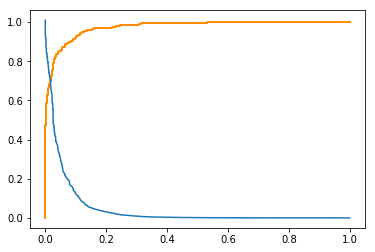

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

test_mask=np.array(results['Type']=='included')

fpr, tpr, threshold = roc_curve(test_mask, results['Predictions'])

roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr,threshold/100)

In [98]:
dd=np.sqrt((fpr)**2+(tpr-1)**2)
idx=np.where(dd==np.min(dd))
threshold[idx[0][0]]

12.323209

In [100]:
pred

array([[9.4607538e-01, 5.3924605e-02],
       [9.9999416e-01, 5.7928082e-06],
       [9.9662530e-01, 3.3747419e-03],
       ...,
       [8.8977140e-01, 1.1022856e-01],
       [5.4120857e-01, 4.5879143e-01],
       [9.7882336e-01, 2.1176657e-02]], dtype=float32)